# Malicious Website Detection
 The dataset used in this project was contributed in IEEE, Kaggle (https://www.kaggle.com/xwolf12/malicious-and-benign-websites) by "Christian Urcuqui". 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


# classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
#scaler
from sklearn.preprocessing import StandardScaler
#pipelines
from sklearn.pipeline import Pipeline

# model selection bits
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import KFold
# evaluation
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# plotting
from plotting import plot_learning_curve, plot_validation_curve



# Data Analysis
 

In [2]:
#dataset loaded
data = pd.read_csv('dataset.csv')
X = data.drop('Type', axis = 1)
y = data.Type

In [3]:
data.head(5)


,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0


In [4]:
#null values checking
data.isnull().any()

URL                          False
URL_LENGTH                   False
NUMBER_SPECIAL_CHARACTERS    False
CHARSET                      False
SERVER                        True
CONTENT_LENGTH                True
WHOIS_COUNTRY                False
WHOIS_STATEPRO               False
WHOIS_REGDATE                False
WHOIS_UPDATED_DATE           False
TCP_CONVERSATION_EXCHANGE    False
DIST_REMOTE_TCP_PORT         False
REMOTE_IPS                   False
APP_BYTES                    False
SOURCE_APP_PACKETS           False
REMOTE_APP_PACKETS           False
SOURCE_APP_BYTES             False
REMOTE_APP_BYTES             False
APP_PACKETS                  False
DNS_QUERY_TIMES               True
Type                         False
dtype: bool

In [5]:
#class distribution
data.groupby('Type').size()

Type
0    1565
1     216
dtype: int64

In [6]:
tuple(y.shape)

(1781,)

In [7]:
tuple(X.shape)

(1781, 20)

In [8]:
data.isnull().any().sum()

3

In [9]:
data.Type.sum() / data.shape[0]

0.12128017967434025

# Data Preprocessing

In [10]:
# Get categorical features
categorical_features = list(X.columns[X.dtypes == object].values)
print(f'Categorical features: {categorical_features}')

# Get numerical features
numerical_features = list(X.columns[X.dtypes != object].values[:-1])
print(f'Numerical features: {numerical_features}')

Categorical features: ['URL', 'CHARSET', 'SERVER', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']
Numerical features: ['URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'CONTENT_LENGTH', 'TCP_CONVERSATION_EXCHANGE', 'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS', 'APP_BYTES', 'SOURCE_APP_PACKETS', 'REMOTE_APP_PACKETS', 'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES', 'APP_PACKETS']


In [11]:
#Cardinality checking
cardinality = (data[categorical_features].nunique() / data[categorical_features].count())
print(f'Cardinality:\n\n{cardinality}')


Cardinality:

URL                   1.000000
CHARSET               0.005053
SERVER                0.134270
WHOIS_COUNTRY         0.027513
WHOIS_STATEPRO        0.102190
WHOIS_REGDATE         0.500281
WHOIS_UPDATED_DATE    0.333520
dtype: float64


In [12]:
#High cardinality features are removed
X = data.drop(labels = ['URL', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO', 'WHOIS_REGDATE','SERVER', 'WHOIS_UPDATED_DATE'], axis = 1)

#Categorical values in CHARSET is splitted using get_dummies
converter = pd.get_dummies(X['CHARSET'])
X= pd.concat((X,converter), axis = 1)
X.drop(['CHARSET'], axis = 1, inplace=True)
X.head()

#None values are replaced with mean
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_ = imp.fit_transform(X)
X= pd.DataFrame(X_, columns=X.columns)

In [13]:
X.isnull().any()

URL_LENGTH                   False
NUMBER_SPECIAL_CHARACTERS    False
CONTENT_LENGTH               False
TCP_CONVERSATION_EXCHANGE    False
DIST_REMOTE_TCP_PORT         False
REMOTE_IPS                   False
APP_BYTES                    False
SOURCE_APP_PACKETS           False
REMOTE_APP_PACKETS           False
SOURCE_APP_BYTES             False
REMOTE_APP_BYTES             False
APP_PACKETS                  False
DNS_QUERY_TIMES              False
Type                         False
ISO-8859                     False
ISO-8859-1                   False
None                         False
UTF-8                        False
iso-8859-1                   False
us-ascii                     False
utf-8                        False
windows-1251                 False
windows-1252                 False
dtype: bool

In [14]:
#Train and Test data are separated
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, stratify=y)

In [15]:
#RandomForest Classifier(solution model)
model_rf = RandomForestClassifier(n_estimators=10, class_weight={0:1.0, 1:7.0})
rf_pipeline = Pipeline([('scaler',StandardScaler()),('clfrf', model_rf)])
rf_pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clfrf',
                 RandomForestClassifier(class_weight={0: 1.0, 1: 7.0},
                                        n_estimators=10))])

In [16]:
#SVM model(Benchmark model)
model_svm = SVC(gamma='scale', class_weight={0:1.0, 1:7.0})
svm_pipeline = Pipeline([('scaler',StandardScaler()),('clfsvm', model_svm)])
svm_pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clfsvm', SVC(class_weight={0: 1.0, 1: 7.0}))])

In [17]:
print(f'Training dataset dimensions: {X_train.shape}')
print(f'Test dataset dimensions: {X_test.shape}')
X_train.describe()


Training dataset dimensions: (1246, 23)
Test dataset dimensions: (535, 23)


,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,...,Type,ISO-8859,ISO-8859-1,None,UTF-8,iso-8859-1,us-ascii,utf-8,windows-1251,windows-1252
count,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1.246000e+03,1246.000000,1246.000000,1.246000e+03,...,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000
mean,56.756019,11.053772,11491.079139,16.742376,5.739968,3.062600,3.602760e+03,19.104334,19.384430,1.653115e+04,...,0.121188,0.000803,0.231942,0.004013,0.385233,0.069823,0.085875,0.220706,0.000803,0.000803
std,27.341626,4.340100,19678.707390,45.527575,25.129060,3.316881,6.699430e+04,46.561929,51.836497,7.826270e+04,...,0.326476,0.028330,0.422242,0.063245,0.486846,0.254952,0.280292,0.414889,0.028330,0.028330
min,17.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,8.000000,1500.250000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,49.000000,10.000000,11726.927761,7.000000,0.000000,2.000000,7.020000e+02,8.500000,9.000000,6.165000e+02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,68.000000,13.000000,11726.927761,22.000000,5.000000,5.000000,2.340250e+03,27.000000,25.000000,9.978000e+03,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,249.000000,40.000000,359174.000000,1194.000000,708.000000,16.000000,2.362906e+06,1198.000000,1284.000000,2.060012e+06,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
#Train set count
y_train.value_counts()

0    1095
1     151
Name: Type, dtype: int64

In [19]:
#Test set count
y_test.value_counts()

0    470
1     65
Name: Type, dtype: int64

In [20]:
tuple(X.shape)

(1781, 23)

# Cross Validation


### Random Forest Cross Validation score

In [21]:
scoringrf = {'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score)}
cv = StratifiedShuffleSplit(n_splits = 100, test_size=.2)
def average_score_on_cross_val_classification(rf_pipeline, X_train, y_train, scoring=scoringrf, cv=cv):
    
    # Score metrics on cross-validated dataset
    scores_dict = cross_validate(rf_pipeline, X_train, y_train, scoring=scoringrf, cv=cv)

    # return the average scores for each metric
    return {metric: round(np.mean(scores), 3)  for metric, scores in scores_dict.items()}
average_score_on_cross_val_classification(rf_pipeline, X_train, y_train)


{'fit_time': 0.032,
 'score_time': 0.009,
 'test_precision': 1.0,
 'test_recall': 0.979,
 'test_f1': 0.989}

### SVM Cross Validation score

In [22]:
scoring_dummy = {'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score)}
cv = StratifiedShuffleSplit(n_splits = 10, test_size=.2)
def average_score_on_cross_val_classification(svm_pipeline, X_train, y_train, scoring=scoring_dummy, cv=cv):
    
    # Score metrics on cross-validated dataset
    scores_dict = cross_validate(svm_pipeline, X_train, y_train, scoring=scoring_dummy, cv=cv)

    # return the average scores for each metric
    return {metric: round(np.mean(scores), 3)  for metric, scores in scores_dict.items()}
average_score_on_cross_val_classification(svm_pipeline, X_train, y_train)

{'fit_time': 0.015,
 'score_time': 0.009,
 'test_precision': 1.0,
 'test_recall': 0.987,
 'test_f1': 0.993}

# Parameter Tuning

### Random Forest




In [23]:
#max_depth,min_samples_leaf,min_samples_split and class_weight parameter used for random forest
param_grid = {'clfrf__max_depth':[2,10,20,30], 'clfrf__min_samples_leaf':[2,10,20,30], 'clfrf__min_samples_leaf':[2,10,20,30], 'clfrf__class_weight':[{0:1,1:10},{0:1,1:7},{0:1,1:100}]}
rf_grid = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='f1')
grid_search = rf_grid.fit(X_train , y_train)

In [24]:
print("Best Parameters= {}".format(rf_grid.best_params_))
print("Best Score= {}".format(rf_grid.best_score_))
print("Best Estimator= {}".format(rf_grid.best_estimator_))

Best Parameters= {'clfrf__class_weight': {0: 1, 1: 10}, 'clfrf__max_depth': 10, 'clfrf__min_samples_leaf': 2}
Best Score= 0.9967213114754099
Best Estimator= Pipeline(steps=[('scaler', StandardScaler()),
                ('clfrf',
                 RandomForestClassifier(class_weight={0: 1, 1: 10},
                                        max_depth=10, min_samples_leaf=2,
                                        n_estimators=10))])


### SVM

In [25]:
#class_weight,gamma,C and max_iter are the parameters used for svm
svmparam_grid = {'clfsvm__class_weight': [{0: 1.0, 1: 7.0}], 'clfsvm__gamma':[.01, 1.0], 'clfsvm__C':[0.01, .0001], 'clfsvm__max_iter':[10000,100000]}
svmgrid = GridSearchCV(svm_pipeline, svmparam_grid, cv=5, scoring='f1')
grid_search = svmgrid.fit(X_train , y_train)

In [26]:
print("Best Parameters= {}".format(svmgrid.best_params_))
print("Best Score= {}".format(svmgrid.best_score_))
print("Best Estimator= {}".format(svmgrid.best_estimator_))


Best Parameters= {'clfsvm__C': 0.01, 'clfsvm__class_weight': {0: 1.0, 1: 7.0}, 'clfsvm__gamma': 0.01, 'clfsvm__max_iter': 10000}
Best Score= 0.9933333333333334
Best Estimator= Pipeline(steps=[('scaler', StandardScaler()),
                ('clfsvm',
                 SVC(C=0.01, class_weight={0: 1.0, 1: 7.0}, gamma=0.01,
                     max_iter=10000))])


# Learning Curves

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>)

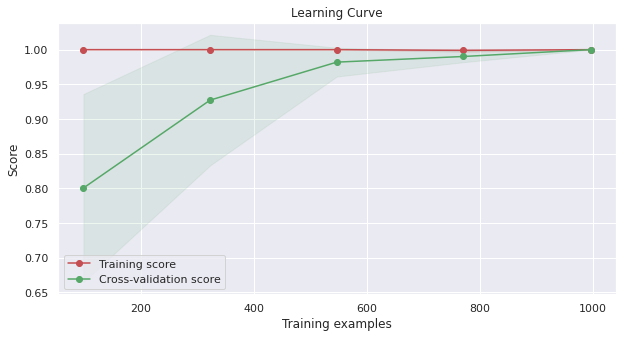

In [27]:
#Random forest learning curve
plot_learning_curve(rf_pipeline, X_train, y_train, cv=KFold(5), train_sizes=np.linspace(0.1, 1.0, 5), scoring='f1')

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>)

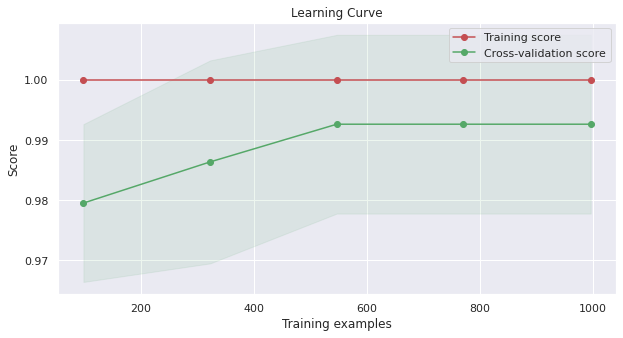

In [28]:
#svm learning curve
plot_learning_curve(svm_pipeline, X_train, y_train, cv=KFold(5), train_sizes=np.linspace(0.1, 1.0, 5), scoring='f1')

# Validation Curves


(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':"Validation Curve with <class 'sklearn.pipeline.Pipeline'>"}, xlabel='clfrf__max_depth', ylabel='f1'>)

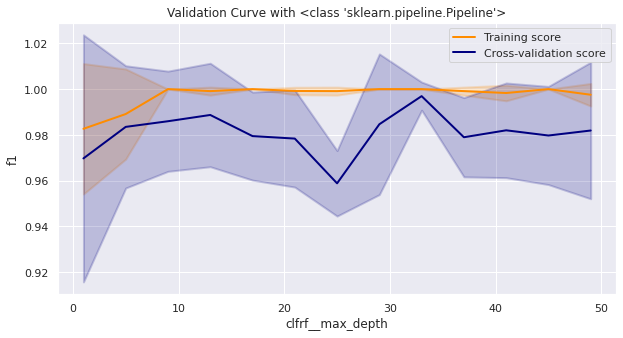

In [29]:
# Randomforest Validation curve 1
plot_validation_curve(rf_pipeline, X_train, y_train, cv=KFold(5), param_range=np.arange(1,50,4), param_name="clfrf__max_depth", scoring='f1')

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':"Validation Curve with <class 'sklearn.pipeline.Pipeline'>"}, xlabel='clfrf__min_samples_leaf', ylabel='f1'>)

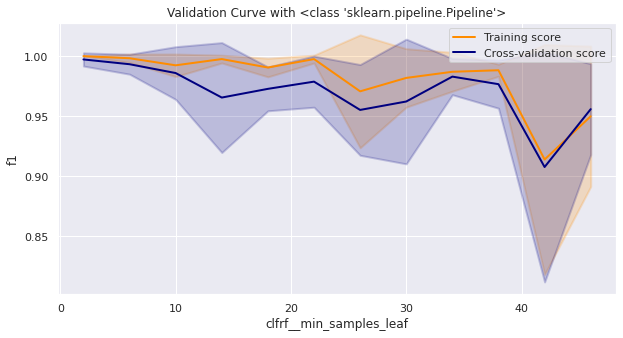

In [30]:
# Randomforest Validation curve 2
plot_validation_curve(rf_pipeline, X_train, y_train, cv=KFold(5), param_range=np.arange(2,50,4), param_name="clfrf__min_samples_leaf", scoring='f1')

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':"Validation Curve with <class 'sklearn.pipeline.Pipeline'>"}, xlabel='clfrf__min_samples_split', ylabel='f1'>)

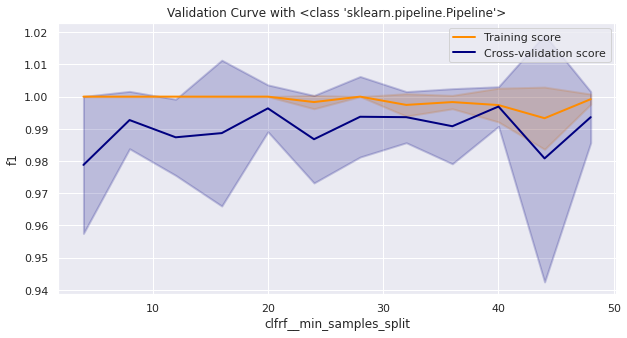

In [31]:
# Randomforest Validation curve 3
plot_validation_curve(rf_pipeline, X_train, y_train, cv=KFold(5), param_range=np.arange(4,50,4), param_name="clfrf__min_samples_split", scoring='f1')

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':"Validation Curve with <class 'sklearn.pipeline.Pipeline'>"}, xlabel='clfsvm__gamma', ylabel='f1'>)

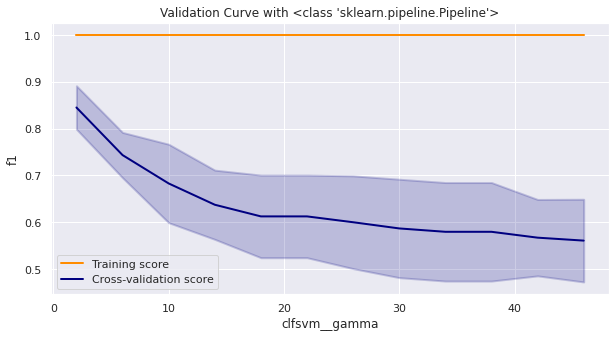

In [32]:
#svm validation curve 1
plot_validation_curve(svm_pipeline, X_train, y_train, cv=KFold(5), param_range=np.arange(2,50,4), param_name="clfsvm__gamma", scoring='f1')

# Testing

### Random Forest Classifier

In [33]:
#Random forest testing and train and test score checking
rf_train_f1score = []
rf_test_f1score = []
rf_train_recallscore = []
rf_test_recallscore = []
rf_train_precisionscore = []
rf_test_precisionscore = []
weights=dict({0:1,1:7})
model = RandomForestClassifier(n_estimators=10, class_weight=weights, max_depth=5, min_samples_leaf=33, min_samples_split=32)
clf_rf = Pipeline([('scaler',StandardScaler()),('clf', model)])
clf_rf.fit(X_train, y_train)
rf_train_preds = clf_rf.predict(X_train)
rf_test_preds = clf_rf.predict(X_test)
rf_train_f1score.append(f1_score(y_train, rf_train_preds))
rf_test_f1score.append(f1_score(y_test, rf_test_preds))
rf_train_recallscore.append(recall_score(y_train, rf_train_preds))
rf_test_recallscore.append(recall_score(y_test, rf_test_preds))
rf_train_precisionscore.append(precision_score(y_train, rf_train_preds))
rf_test_precisionscore.append(precision_score(y_test, rf_test_preds))
print(f"Training f1 score is {rf_train_f1score}")
print(f"Testing f1 score is {rf_test_f1score}\n") 
print(f"Training recall score is {rf_train_recallscore}")
print(f"Testing recall score is {rf_test_recallscore}\n") 
print(f"Training precision score is {rf_train_precisionscore}")
print(f"Testing precision score is {rf_test_precisionscore}") 


Training f1 score is [1.0]
Testing f1 score is [0.9922480620155039]

Training recall score is [1.0]
Testing recall score is [0.9846153846153847]

Training precision score is [1.0]
Testing precision score is [1.0]


Random Forest classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       470
           1       1.00      0.98      0.99        65

    accuracy                           1.00       535
   macro avg       1.00      0.99      1.00       535
weighted avg       1.00      1.00      1.00       535

Random Forest Confusion matrix : 
 [[470   0]
 [  1  64]]


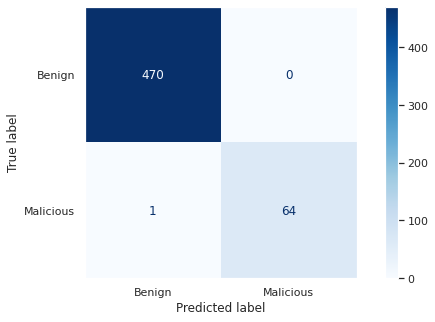

In [34]:
## Randomforest Classification Report and confusion matrix
rf_matrix = classification_report(y_test, rf_test_preds)
print('Random Forest classification report : \n',rf_matrix)
rf_matrix = confusion_matrix(y_test,rf_test_preds )
print('Random Forest Confusion matrix : \n',rf_matrix)

Type=["Malicious","Benign"]
rf_confusion = ConfusionMatrixDisplay(confusion_matrix(y_test,rf_test_preds), display_labels=np.flip(Type))
fig, ax = plt.subplots(figsize=(10,5))
plt.grid(False)
rf_confusion.plot(ax = ax, cmap='Blues', xticks_rotation = 0)

### SVM Classifier

In [35]:
#SVM testing and train and test score checking
svm_train_f1score = []
svm_test_f1score = []
svm_train_recallscore = []
svm_test_recallscore = []
svm_train_precisionscore = []
svm_test_precisionscore = []
model_svm = SVC(gamma=.1,C=.01, class_weight={0:1.0, 1:7.0}, max_iter=10000)
clf_svm = Pipeline([('scaler',StandardScaler()),('clf2', model_svm)])
clf_svm.fit(X_train, y_train)
svm_train_preds = clf_svm.predict(X_train)
svm_test_preds = clf_svm.predict(X_test)
svm_train_f1score.append(f1_score(y_train, svm_train_preds))
svm_test_f1score.append(f1_score(y_test, svm_test_preds))
svm_train_recallscore.append(recall_score(y_train, svm_train_preds))
svm_test_recallscore.append(recall_score(y_test, svm_test_preds))
svm_train_precisionscore.append(precision_score(y_train, svm_train_preds))
svm_test_precisionscore.append(precision_score(y_test, svm_test_preds))
print(f"Training f1 score is {svm_train_f1score}")
print(f"Testing f1 score is {svm_test_f1score}\n") 
print(f"Training recall score is {svm_train_recallscore}")
print(f"Testing recall score is {svm_test_recallscore}\n") 
print(f"Training precision score is {svm_train_precisionscore}")
print(f"Testing precision score is {svm_test_precisionscore}") 

Training f1 score is [0.976271186440678]
Testing f1 score is [0.9166666666666666]

Training recall score is [0.9536423841059603]
Testing recall score is [0.8461538461538461]

Training precision score is [1.0]
Testing precision score is [1.0]


SVM classification report : 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       470
           1       1.00      0.85      0.92        65

    accuracy                           0.98       535
   macro avg       0.99      0.92      0.95       535
weighted avg       0.98      0.98      0.98       535

SVM confusion matrix : 
 [[470   0]
 [ 10  55]]


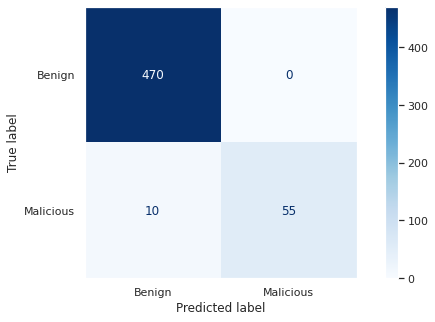

In [36]:
## SVM Classification Report and confusion matrix
svm_matrix = classification_report(y_test, svm_test_preds)
print('SVM classification report : \n',svm_matrix)
svm_matrix = confusion_matrix(y_test,svm_test_preds )
print('SVM confusion matrix : \n',svm_matrix)

Type=["Malicious","Benign"]
svm_confusion = ConfusionMatrixDisplay(confusion_matrix(y_test,svm_test_preds), display_labels=np.flip(Type))
fig, ax = plt.subplots(figsize=(10,5))
plt.grid(False)
svm_confusion.plot(ax = ax, cmap='Blues', xticks_rotation = 0)

### Dummy Classifier

In [37]:
#Dummy Classifier
dummy_pipeline=DummyClassifier(strategy='stratified')
dummy_pipeline.fit(X_train, y_train)
dummy_prediction=dummy_pipeline.predict(X_test)

In [38]:
# F1-score, precision and recall score checking
print("F1-score = {}".format(metrics.f1_score(y_test, dummy_prediction)))
print("Precision = {}".format(metrics.precision_score(y_test, dummy_prediction)))
print("Recall = {}".format(metrics.recall_score(y_test, dummy_prediction)))

F1-score = 0.16793893129770993
Precision = 0.16666666666666666
Recall = 0.16923076923076924


Dummy classification report : 
               precision    recall  f1-score   support

           0       0.88      0.88      0.88       470
           1       0.17      0.17      0.17        65

    accuracy                           0.80       535
   macro avg       0.53      0.53      0.53       535
weighted avg       0.80      0.80      0.80       535

Dummy confusion matrix : 
 [[415  55]
 [ 54  11]]


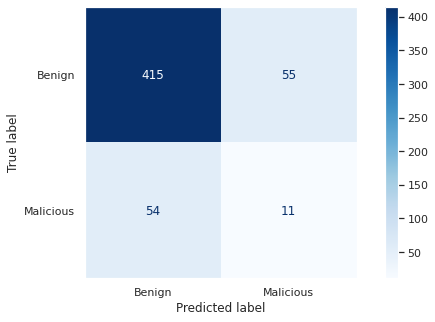

In [39]:
## Dummy Classification Report and confusion matrix
svm_matrix = classification_report(y_test,dummy_prediction)
print('Dummy classification report : \n',svm_matrix)
svm_matrix = confusion_matrix(y_test,dummy_prediction)
print('Dummy confusion matrix : \n',svm_matrix)

Type=["Malicious","Benign"]
dummy_confusion = ConfusionMatrixDisplay(confusion_matrix(y_test,dummy_prediction), display_labels=np.flip(Type))
fig, ax = plt.subplots(figsize=(10,5))
plt.grid(False)
dummy_confusion.plot(ax = ax, cmap='Blues', xticks_rotation = 0)